# Tfidf Logistic Regression Classifier

### Introduction

This is a simple introduciton to text classifciation in Python. We will take thousands of movie reviews and use them to predict the sentiment of unseen reviews. 

The sample has been taken [Kaggle]( https://www.kaggle.com/c/word2vec-nlp-tutorial/data) (labelledTrainData.tsv). If you save this file to your desktop and reference the folder on your machine then you should be able to replicate the results. 
    
We will call upon powerful Python libraries **nltk** and **scikitlearn**. We will also use the pipeline process to build a term frequency-inverse document frequency (tfidf) based logistic regression model. We will consider a few parameter options and use cross validation methods.~


### Import Packages

In [1]:
#Change this to the location of your data. This is my location...
Path="/home/laptopadmin/Documents/Git/Text_Classification_Model/labeledTrainData.tsv"

In [2]:
import pandas as pd
import numpy as np
import nltk

import warnings #Using Python 2.7. There will be some version warnings that we don't need to see.
warnings.filterwarnings("ignore")

#from sklearn.externals import joblib #I will add this back in when I'm ready to pickle the data.

from nltk.corpus import stopwords
stopwords=set(stopwords.words('english'))

### Read data

In this example there are two key columns.
- A "Sentiment" column indicating whether someone liked or disliked the movie.
- A "Review" column containing the review itself.

Next let's just take a quick look at our data to check everything looks okay.

In [3]:
moviedata = pd.read_csv(Path, header=0, delimiter="\t", quoting=3)

In [4]:
moviedata[0:5]

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [5]:
moviedata.review[1000]

'"I watched this movie really late last night and usually if it\'s late then I\'m pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it\'s suppose to be a comedy but I didn\'t find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it\'s definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it\'s just too annoying."'

#### Let's check how much data we have and check whether we have an even split.

In [6]:
moviedata.groupby("sentiment").count()

,id,review
sentiment,,
0,12500,12500
1,12500,12500


It looks like we have 25,000 items of data, evenly spread

### Import more libraries

Okay so we've got a bunch of scikit learn stuff to import here. 

In [7]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.cross_validation import train_test_split, cross_val_score #Note train_test_split has moved around depending on the Python version 

from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB, BernoulliNB
#from sklearn.linear_model import SGDClassifier
#from sklearn.svm import SVC, LinearSVC, NuSVC
#from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix, roc_curve

### Test Train Split

Next we create our train and test sets. We will use a 70:30 split. The approach here is the standard one used in scikit learn. Once we have our data in X_train, X_test, y_train and y_test we will have an enormous amount of flexibility wtih what we can do with the data.

In [8]:
X=moviedata['review']
y=moviedata['sentiment']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3)

print("train length: ", len(X_train),
      "\ntest length: ", len(X_test),
      "\noverall length: ", len(y_train) + len(y_test))

train length:  17500 
test length:  7500 
overall length:  25000


### Tfidf-Logistic Regresison Pipeline

Quite a few things happen in this stage. Firstly we use **pipeline** to join together three processes straightforwardly. The three components are as follows:

1. We first use a [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). This is a big matrix containing every document in one dimension and every word in the other. The cells are populated with counts.

2. Next we use a [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). This transforms the count data into tf-idf scores. Tf-idf is a method intended to reflect how important a word is to a document in a corpus (a collection of documents). The tf-idf score will increase the  more times it appears in a document but is offset by the frequency of the word in the corpus. There are some words that occur very frequently in general and they will be penalised using this method. 

3. Finally we use [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). This is a model used to predict binary outcomes. In this case we are predicting whether or not a review is positive based on the words in the document.

Once this pipeline is created we can use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [RandomisedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). These powerful functions have two important properties.

- Firstly they enables us to try out a wide range of parameter model choices. GridSearch will explore all  permutations, whereas RandomisedSearch will cover just some of them.

- Secondly they perform cross validation on the data. This is a method for partitioning the data into a training and validation set multiple times using different permutations.

**GridSearchCV** can take a considerable time to run. We can improve computational expense using **RandomisedSearchCV** instead which is what we do here.

We can feed RandomisedSearchCV a number of parameter options:
- ngram_range tells is whether we want single words, bigrams of trigrams
- min_df removes words that only appear in a small number of documents (df stands for document frequency).
- max_df removes words that appear in more than a certain numnber of documents
- C is a regulirisation paramater for Logisitic Regression that helps prevent overfitting by downweighting some of the model parameters.

In [9]:
pipeline = Pipeline([
    ('vec', CountVectorizer(stop_words=stopwords)), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', LogisticRegression())  
])


ngram_range=[(1,1),(1, 2),(1,3)] #single words, bigrams and trigrams
min_df=[2,3,4] #kick out words that occur in less than 3 or 4 documents
#max_df=[0.5,1] #kick out words occuring in more than half the documents or don't.
#use_idf=[True, False] #use idf as part of tfidf. This is boolean.
Cs = [1, 10, 20] #Regularisation paramater for the logistic regression
#alpha=[.1] #Smoothing if using multinomial bayes

params= dict(vec__ngram_range=ngram_range,
                              vec__min_df=min_df,
                              #vec__max_df=max_df, 
                              #tfidf__use_idf=use_idf
                              #classifier__alpha=alpha
                              classifier__C=Cs)
            
#grid = GridSearchCV(pipeline, params,cv=2, scoring='accuracy')
rand = RandomizedSearchCV(pipeline, params, cv=5, scoring='accuracy', n_iter=8, )

rand.fit(X_train, y_train)

#To run other models can replace the classifier using any of the following lines:
#('classifier', Logistic Regression())
#('classifier', MultinomialNB())
#('classifier', BernoulliNB())
#('classifier', SGDClassifier())  
#('classifier', SVC()) 
#('classifier', LinearSVC())
#('classifier', DecisionTreeClassifier()) 

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'a', 'could...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'vec__ngram_range': [(1, 1), (1, 2), (1, 3)], 'vec__min_df': [2, 3, 4], 'classifier__C': [1, 10, 20]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='accuracy', verbose=0)

### Model Review

We can take a look at the results of the numerous permutations of parameter combinations.

In [10]:
rand.grid_scores_

[mean: 0.88606, std: 0.00820, params: {'vec__ngram_range': (1, 3), 'vec__min_df': 3, 'classifier__C': 1},
 mean: 0.89314, std: 0.00600, params: {'vec__ngram_range': (1, 2), 'vec__min_df': 4, 'classifier__C': 20},
 mean: 0.89423, std: 0.00706, params: {'vec__ngram_range': (1, 3), 'vec__min_df': 2, 'classifier__C': 10},
 mean: 0.88840, std: 0.00533, params: {'vec__ngram_range': (1, 1), 'vec__min_df': 4, 'classifier__C': 10},
 mean: 0.88846, std: 0.00508, params: {'vec__ngram_range': (1, 1), 'vec__min_df': 3, 'classifier__C': 10},
 mean: 0.88554, std: 0.00848, params: {'vec__ngram_range': (1, 2), 'vec__min_df': 3, 'classifier__C': 1},
 mean: 0.88514, std: 0.00571, params: {'vec__ngram_range': (1, 1), 'vec__min_df': 4, 'classifier__C': 1},
 mean: 0.88954, std: 0.00480, params: {'vec__ngram_range': (1, 1), 'vec__min_df': 2, 'classifier__C': 10}]

Let's look at the first result in more detail. We cansee what parameters were fitted, what the cross validation scores were and what the mean of those scores was.

In [11]:
print(rand.grid_scores_[0].parameters)
print(rand.grid_scores_[0].cv_validation_scores)
print(rand.grid_scores_[0].mean_validation_score)

{'vec__ngram_range': (1, 3), 'vec__min_df': 3, 'classifier__C': 1}
[ 0.89        0.87657143  0.87885714  0.88542857  0.89942857]
0.8860571428571429


Okay so this one was okay but it wasn't the best. Let's take a look at the best results.

In [12]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.8942285714285715
{'vec__ngram_range': (1, 3), 'vec__min_df': 2, 'classifier__C': 10}


We will now take this favoured model. Run it on the unused test sets and look at some classification stats. 

### Model Evaluation

First lets check the performance of the model. We are most interested in the result of the test set since the model wasn't fitted on that data. Lets do that.

In [13]:
predictions_test=rand.predict(X_test)

In [14]:
print(confusion_matrix(y_test,predictions_test))
print("")
print(classification_report(y_test,predictions_test))

[[3343  442]
 [ 320 3395]]

             precision    recall  f1-score   support

          0       0.91      0.88      0.90      3785
          1       0.88      0.91      0.90      3715

avg / total       0.90      0.90      0.90      7500



<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

Overall a very good performance. 
- The precision rate tells us how many of our selected items are relevant. We see around 90% with an even balance across categories.
- Recall tells us how many relevant items we selected. We see around 90% in our case, again with even balance.


Let's take a look at some plots of the predictions:

In [15]:
y_test_preds=rand.predict_proba(X_test)[:, 1]

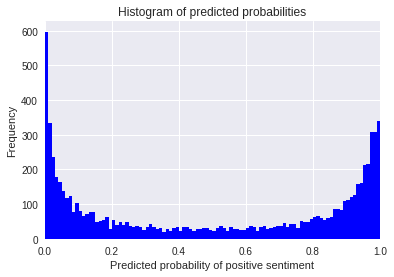

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# histogram of predicted probabilities
plt.hist(y_test_preds, bins=100, color="blue")
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of positive sentiment')
plt.ylabel('Frequency')

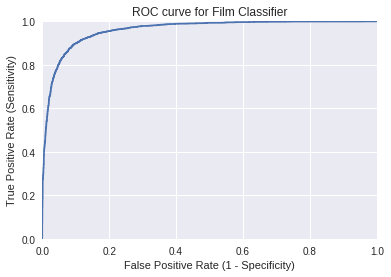

In [17]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_preds)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Film Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [18]:
print(metrics.roc_auc_score(y_test, y_test_preds))

0.960651363408


We see a pretty strong model performance for low effort with area under the curve (auc) of 0.96.

### Summary

- With a small amount of work up front, we can very flexibly explore a wide range of options rapidly.
- The pipeline process enabled us to merge complex components into a few lines of code.
- We were easily able to vary parameters to optimise model choice.
- We got a high model performance with minimal effort. This doesn't mean we can expect this to happen every time but is encouraging.

### Resources

[tfidf wiki](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

[Logisitc regression wiki](https://en.wikipedia.org/wiki/Logistic_regression)

[Precision and recall wiki](https://en.wikipedia.org/wiki/Precision_and_recall)

[SciKit Learn Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

[nltk book](http://www.nltk.org/book/)

[ROC Curve Video](http://www.dataschool.io/roc-curves-and-auc-explained/)